# Real-time $R_t$ computation on Piemonte COVID-19 data, by Stefano Terna$^1$

$^1$ PhD String Theory, [tomorrowdata.io](https://tomorrowdata.io) CEO

## Citations

1. Real Time Bayesian Estimation of the Epidemic Potential of Emerging Infectious Diseases, Luı´s M. A. Bettencourt, Ruy M. Ribeiro, [paper](https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0002185&type=printable)
2. A New Framework and Software to Estimate Time-Varying Reproduction Numbers During Epidemics, Anne Cori, Neil M. Ferguson, Christophe Fraser, and Simon Cauchemez, [paper and supplementary data](https://academic.oup.com/aje/article/178/9/1505/89262)
3. Numero di riproduzione netto al tempo t, [Wikipedia](https://it.wikipedia.org/wiki/Numero_di_riproduzione_di_base#Numero_di_riproduzione_netto_al_tempo_t) 
4. FAQ sul calcolo del Rt, Istituto Superiore di Sanità, [link](https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt)
5. Lockdown Can’t Last Forever. Here’s How to Lift It, Gabriel Leung, University of Hong Kong, [New York Times](https://www.nytimes.com/2020/04/06/opinion/coronavirus-end-social-distancing.html) 
6. Azienda sanitaria dell’Alto Adige, [Risultati](https://coronatest.sabes.it/it/muni) dello Screening a livello provinciale per il contenimento del Coronavirus
7. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 novembre 2020
8. Tikhonov regularization, [Wikipedia](https://en.wikipedia.org/wiki/Tikhonov_regularization)
9. Task force COVID-19 del Dipartimento Malattie Infettive e Servizio di Informatica, Istituto Superiore di Sanità. Epidemia COVID-19, Aggiornamento nazionale: 18 agosto 2020
10. Dati COVID-19 Italia, Protezione Civile, [github](https://github.com/pcm-dpc/COVID-19)

In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../../')

In [2]:
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error
import pymc3 as pm

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling.datarevision.seasonal import draw_expanded_series, smooth_and_drop
from covid19_pytoolbox.modeling.Rt.bayesian import MCMC_sample
from covid19_pytoolbox.utils import smape, padnan

BASE_DATA_PATH='../../data'
BASE_IMAGES_PATH='../../images'

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
date_ = os.environ.get("REF_DATE")
if date_ is None:
    date_ = "2021-04-23"
print(date_)

2021-05-31


# ISS Data

In [4]:
ISS_Rt = pd.read_csv(
    os.path.join(BASE_DATA_PATH, 'sources/Rt_Piemonte_from_ISS.csv'),
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [5]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [6]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = ISS_Rt_clean.Rt - ISS_Rt_clean.Rt_95_min

In [7]:
ISS_Rt_clean['Rt_reference_date'] = (
    (
        ISS_Rt_clean.computation_time_range_start + 
        (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
    ).dt.normalize()+timedelta(days=1, minutes=-1)
)
ISS_Rt_clean.sort_values(by='Rt_reference_date', inplace=True)
ISS_Rt_clean.reset_index(inplace=True, drop=True)

In [8]:
ISS_Rt_clean.tail()

,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,Rt_95_err_max,Rt_95_err_min,Rt_reference_date
17,2021-03-31,2021-04-13,0.70,0.64,0.80,0.10,0.06,2021-04-06 23:59:00
18,2021-04-07,2021-04-20,0.75,0.67,0.80,0.05,0.08,2021-04-13 23:59:00
19,2021-04-14,2021-04-27,0.84,0.77,0.94,0.10,0.07,2021-04-20 23:59:00
20,2021-04-28,2021-05-11,0.81,0.66,0.99,0.18,0.15,2021-05-04 23:59:00
21,2021-05-05,2021-05-18,0.73,0.57,0.87,0.14,0.16,2021-05-11 23:59:00


# DPC Data

In [9]:
ALPHA = 100.
alpha = 1.87
beta = 0.28

In [10]:
def parse_date(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

regions_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv',
    parse_dates=['data'],
    date_parser=parse_date
)
# filter by date: (regions_raw_data.data<'2021-03-03')
#regional_raw_data = regions_raw_data.loc[(regions_raw_data.data<'2021-03-09') & (regions_raw_data.denominazione_regione=='Piemonte')].reset_index().copy()
regional_raw_data = regions_raw_data.loc[(True) & (regions_raw_data.denominazione_regione=='Piemonte')].reset_index().copy()

In [11]:
TIMESTEPS, _ = DPC.preprocess(regional_raw_data)
DPC.compute_first_diffs(regional_raw_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(regional_raw_data, regularizer)
DPC.bulk_compute_naive_Rt(regional_raw_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati': 'hospitalized_cumulative',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_ospedalizzati_smoothed': 'hospitalized_cumulative',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999561259592089
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999908188968333
deceduti_giornalieri_smoothed - TIC R2: 0.9999924055225893
nuovi_positivi_smoothed - TIC R2: 0.9999945004660348
nuovi_casi_da_sospetto_diagnostico_smoot

In [12]:
DPC.RSVD_smooth_data(regional_raw_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

['nuovi_positivi', 'tamponi_giornalieri', 'nuovi_ospedalizzati']
nuovi_positivi_deseason
info_cri:  -0.42936402057901
info_cri:  0.3754840111319866
TIC R2: 0.9740801152000622
patterns: 1
(   -10.180654441948713,
    6.708714666419652e-18,
    16,
    443,
    {   '1%': -3.4451978474132234,
        '10%': -2.5702569996789792,
        '5%': -2.8680864144212057},
    375.4902634379499)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']
tamponi_giornalieri_deseason
info_cri:  -0.3256797666410749
info_cri:  0.2080983917447588
TIC R2: 0.9555317808378082
patterns: 1
(   -7.056457331477018,
    5.359604222721343e-10,
    18,
    441,
    {   '1%': -3.4452655826028318,
        '10%': -2.570272878944473,
        '5%': -2.868116205869215},
    101.86366274512375)
new columns gener

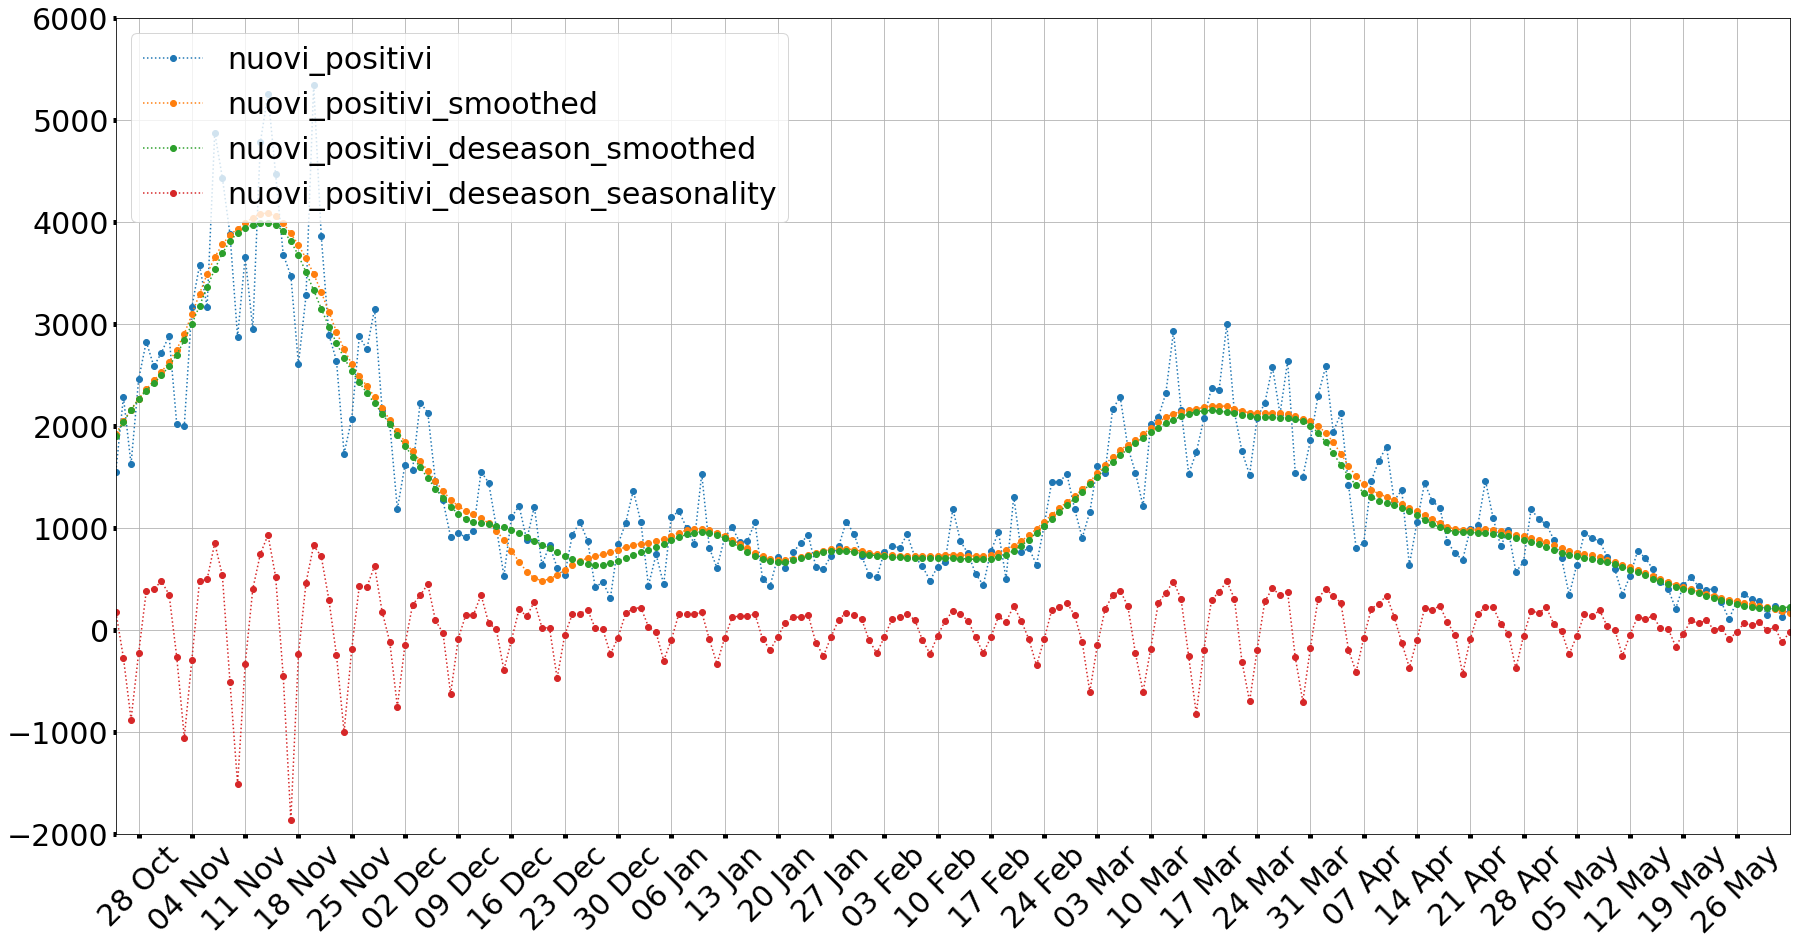

In [13]:
plotting.plot_series(
    df=regional_raw_data,
    xfield='data',
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed',
        'nuovi_positivi_deseason_seasonality'
    ],
    xlim=(datetime(2020,10,25), regional_raw_data.data.max()),
    ylim=(-2000,6000),
    legend_loc="upper left"
)

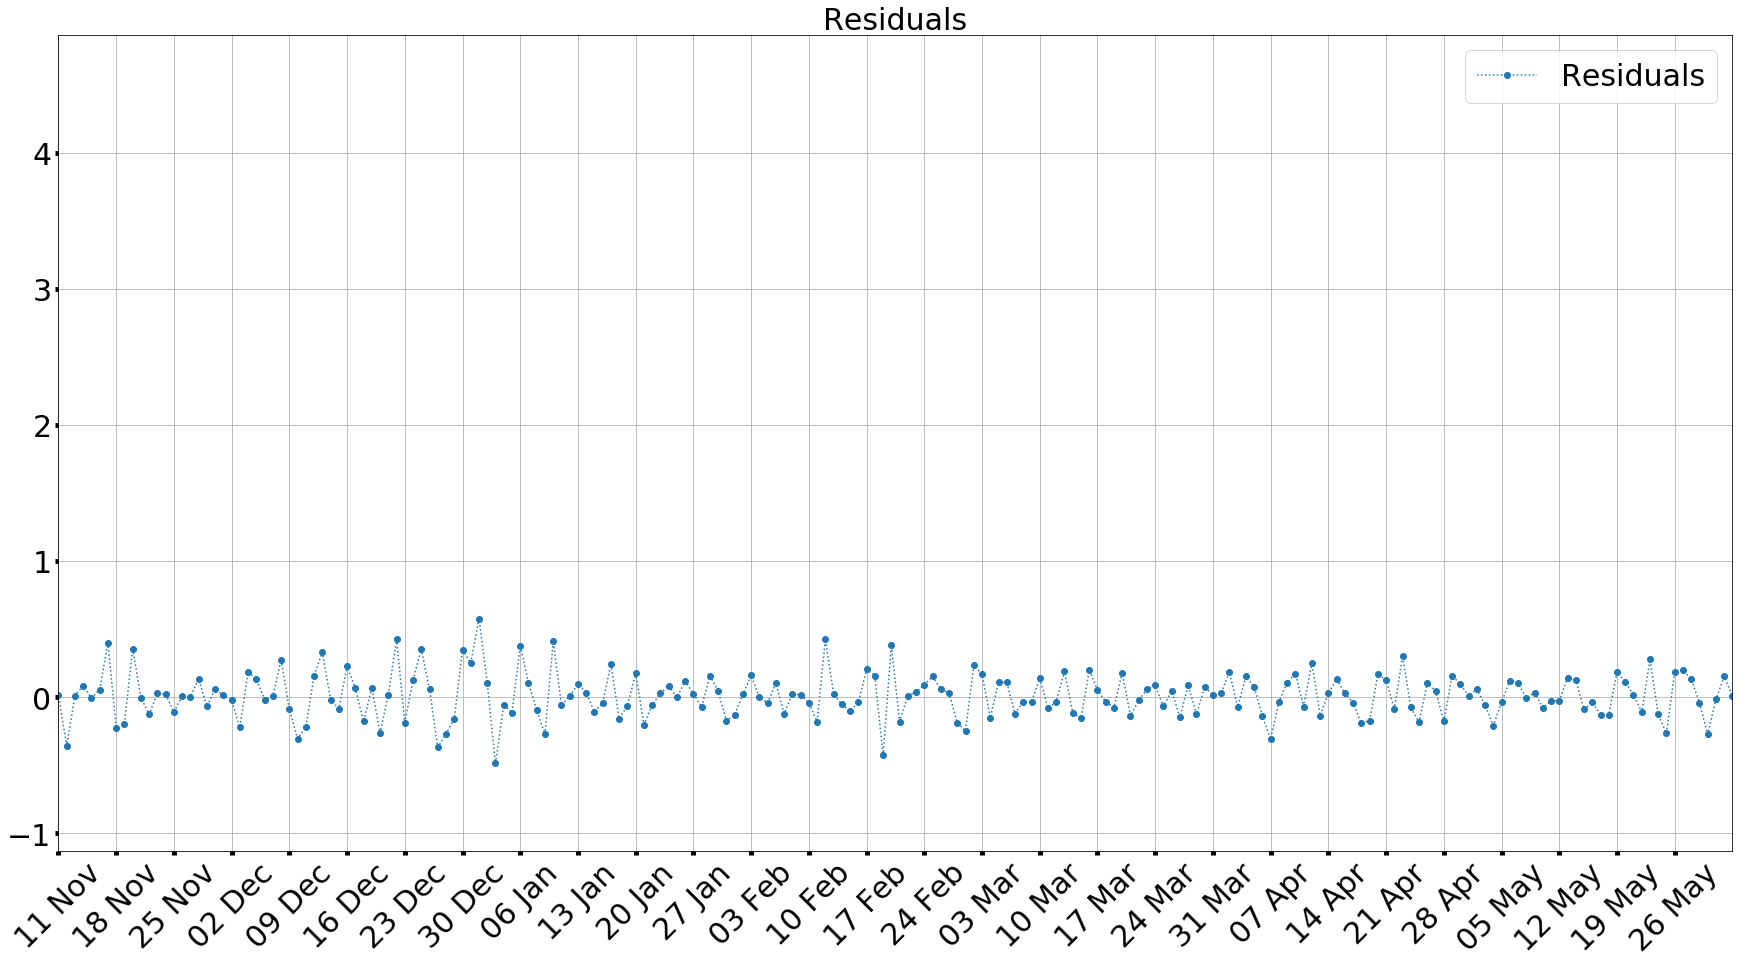

In [14]:
plotting.plot_series(
    title='Residuals',
    data=[{
        'df':regional_raw_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_deseason_relative_residuals',
        ],
        'labels':[
            'Residuals',
        ]
    }],
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), regional_raw_data.data.max()),
    #ylim=(0.6,1.3),
    legend_loc="upper right"
)

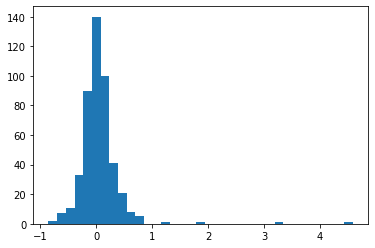

In [15]:
_=plt.hist(regional_raw_data.nuovi_positivi_deseason_relative_residuals,bins=35)

In [16]:
_,_,S=LogSeasonalRegularizer.periods_to_matrix(regional_raw_data.nuovi_positivi_deseason_seasonality.to_numpy(),7)

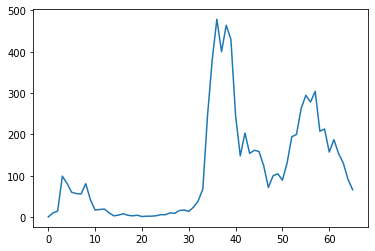

In [17]:
plt.plot(S[:,0])

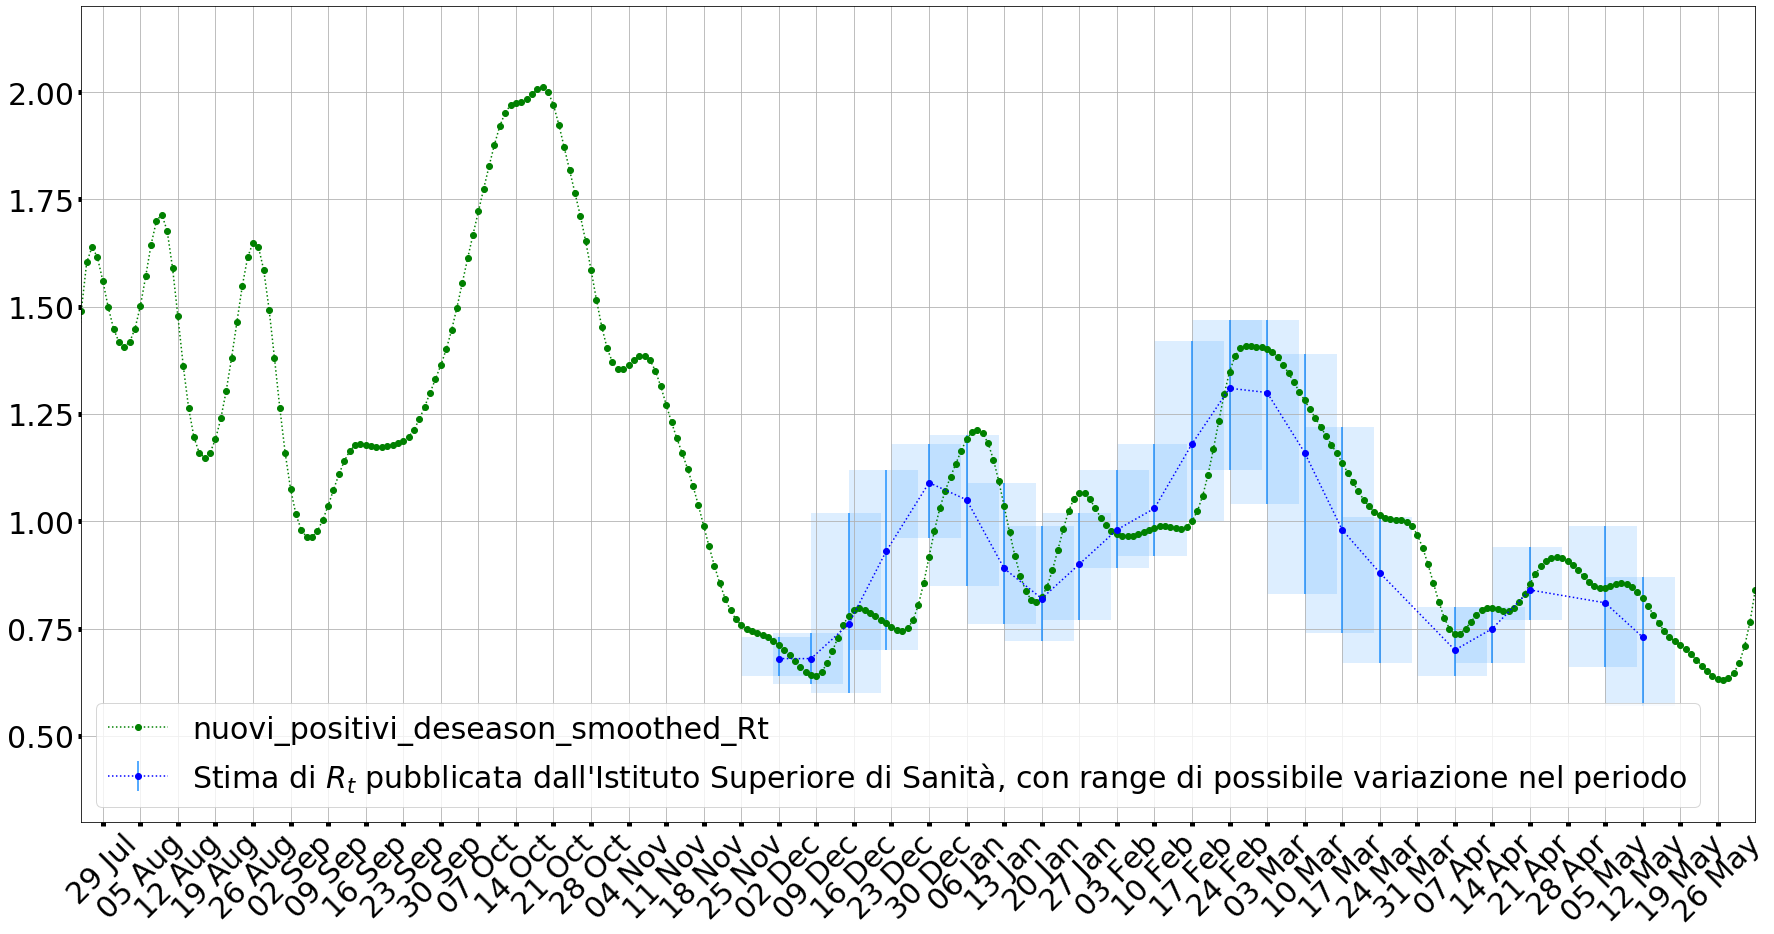

In [18]:
plotting.plot_series(
    data=[
        {
            'df':regional_raw_data,
            'xfield':'data',
            'yfields':[
                'nuovi_positivi_deseason_smoothed_Rt'
            ],
            'colors':['green']
        },
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        }        
    ],
    xlim=(datetime(2020,7,25), regional_raw_data.data.max()),
    ylim=(0.3,2.2),
    legend_loc="lower left",
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'UK_naive_Rt'),
    
)

# Calculation

The actual simulations run on virtual machines on IBM Cloud via the scripts contained in the `applications/` dir.

Here we just load the pickles generated by the simulations.

In [19]:
regional_calc_data = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{date_}_futbound_08_12_Piemonte_MCMC_Rt_pastdays_000_000.pickle')
)

In [20]:
regional_calc_data_prev = pd.read_pickle(
    os.path.join(BASE_DATA_PATH, 
                 f'computed/italy/{"2021-03-31"}_futbound_08_12_Piemonte_MCMC_Rt_pastdays_000_000.pickle')
)

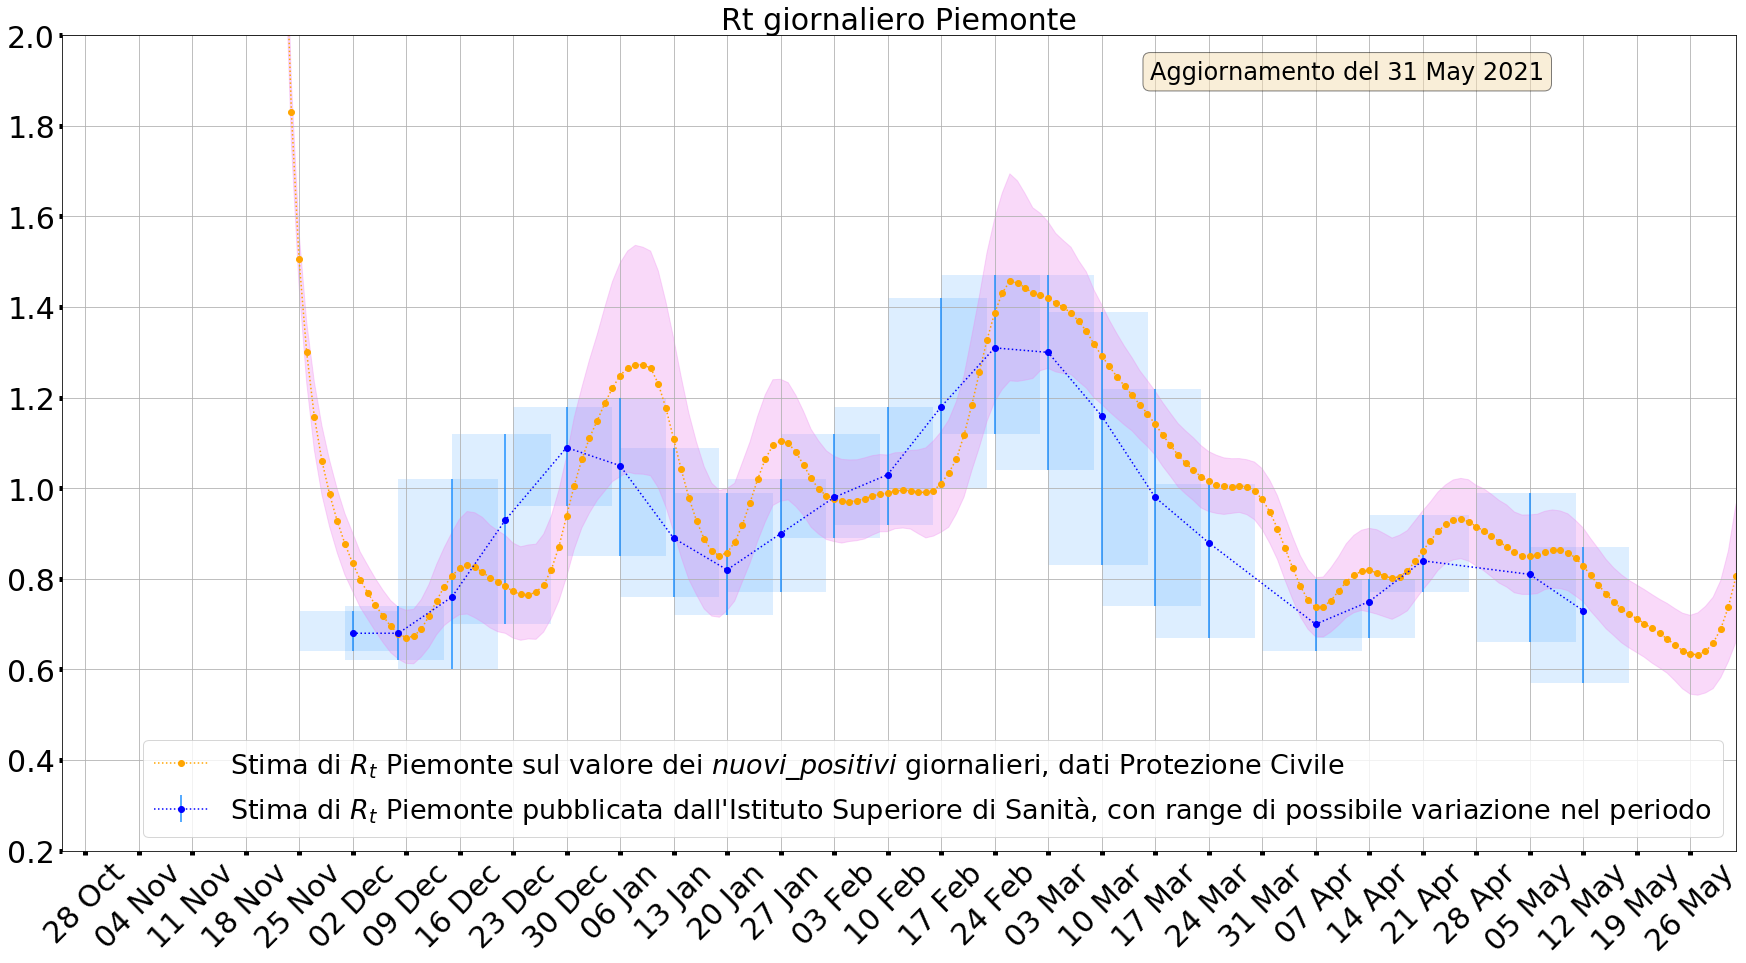

In [21]:
plotting.plot_series(
    title='Rt giornaliero Piemonte',
    message='Aggiornamento del {}'.format(regional_calc_data.data.max().strftime('%d %b %Y')),
    data=[
        {
            'df': ISS_Rt_clean,
            'xfield': 'Rt_reference_date',
            'yfields': ['Rt'],
            'bars': [['Rt_95_err_min','Rt_95_err_max']],
            'timeranges': [['computation_time_range_start', 'computation_time_range_end']],
            'labels': ['Stima di $R_t$ Piemonte pubblicata dall\'Istituto Superiore di Sanità, con range di possibile variazione nel periodo'],
            'colors': ['blue']
        },        
        {
            'df': regional_calc_data,
            'xfield': 'data',
            'yfields': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_000', 
            ],
            'fill_between': [
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_000',
                f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_000',
            ],
            'labels': [
                f'Stima di $R_t$ Piemonte sul valore dei $nuovi\_positivi$ giornalieri, dati Protezione Civile',
            ],
            'colors':['orange']
        },
    ],
    legend_fontsize=27,
    xlim=(datetime(2020,10,25), regional_calc_data.data.max()),
    ylim=(0.2,2),
    legend_loc='lower right',
    #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH, 'italy/regional_Piemonte_20210324_TD_Rt_computation_MCMC_150dpi'),
    dpi=150,
    quality=60
)

In [22]:
regional_calc_data.tail().T

,458,459,460,461,462
index,9631,9652,9673,9694,9715
data,2021-05-27 23:59:00,2021-05-28 23:59:00,2021-05-29 23:59:00,2021-05-30 23:59:00,2021-05-31 23:59:00
stato,ITA,ITA,ITA,ITA,ITA
codice_regione,1,1,1,1,1
denominazione_regione,Piemonte,Piemonte,Piemonte,Piemonte,Piemonte
lat,45.0733,45.0733,45.0733,45.0733,45.0733
long,7.68069,7.68069,7.68069,7.68069,7.68069
ricoverati_con_sintomi,765,653,628,625,594
terapia_intensiva,90,86,84,80,81
totale_ospedalizzati,855,739,712,705,675
